# Project Notebook - Machine Learning I

### Libraries

In [18]:
import pandas as pd
import numpy as np
import openml
from AdaBoostWorkyWorky import AdaBoost
from sklearn.model_selection import KFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import scipy.stats as ss
import matplotlib.pyplot as plt


### Get the datasets to use throughout the project

Function to read a dataset from [OpenML-CC18 Curated Classification benchmark](https://www.openml.org/search?type=study&sort=tasks_included&study_type=task&id=99) givent its Task ID and return the corresponding Pandas Dataframe

In [19]:
def getDataset(task_id):
    suite = openml.study.get_suite(99)
    task = openml.tasks.get_task(task_id)    
    dataset = openml.datasets.get_dataset(task.dataset_id)

    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )

    df = pd.DataFrame(X, columns=attribute_names)
    # converter:
    #   0 -> -1
    #   1 -> 1
    df['target'] = 2*y-1 
    # erase rows with NaN values
    df = df.dropna(how='any', axis=0)

    return df

Description of the datasets used in this project:
- A
- B
- C

In [33]:
datasets = [
    ("Task ID = 15", getDataset(15)),
    ("Task ID = 24", getDataset(24)),
    ("Task ID = 3904", getDataset(3904)),
    ("Task ID = 146820", getDataset(146820))
]

### Performance evaluation of AdaBoost

In [21]:
# function to perform cross validation on a set of algorithms ("algs")
def run_cv(X,y,algs,nfolds=10):
    results = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=1111)
    for algo_name, algo in algs:
        results[algo_name] = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            algo.fit(X_train, y_train)
            y_pred = algo.predict(X_test)
            results[algo_name].append(accuracy_score(y_test, y_pred))
    results_df = pd.DataFrame.from_dict(results)
    return results_df

In [22]:
# running 10-fold cross validation for all datasets and checking accuracy

for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    algs = [("AdaBoost", AdaBoost())]
    result = run_cv(X, y, algs)
    print(f"Mean accuracy for dataset wiht {ds_id} in 10-fold CV: {np.mean(result['AdaBoost']):.5f}")

Mean accuracy for dataset wiht Task ID = 15 in 10-fold CV: 0.95759
Mean accuracy for dataset wiht Task ID = 24 in 10-fold CV: 0.97785
Mean accuracy for dataset wiht Task ID = 3904 in 10-fold CV: 0.80928
Mean accuracy for dataset wiht Task ID = 167125 in 10-fold CV: 0.86062


In [23]:
# function to plot the Confusion Matrix of a fitted model
def plot_cm(model_fit,X_test,y_test):
    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

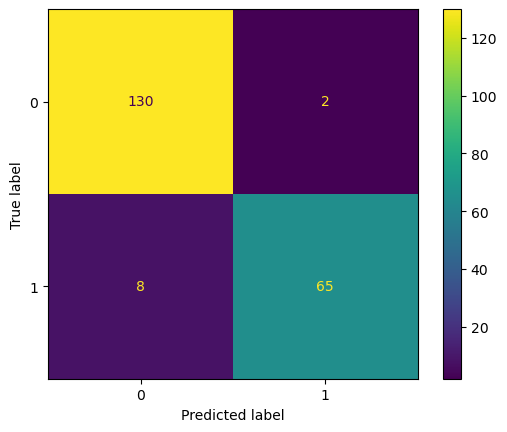

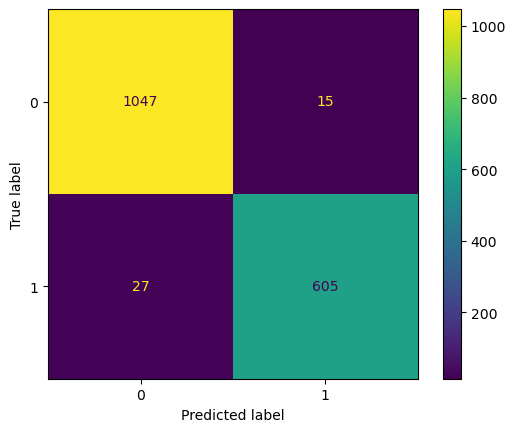

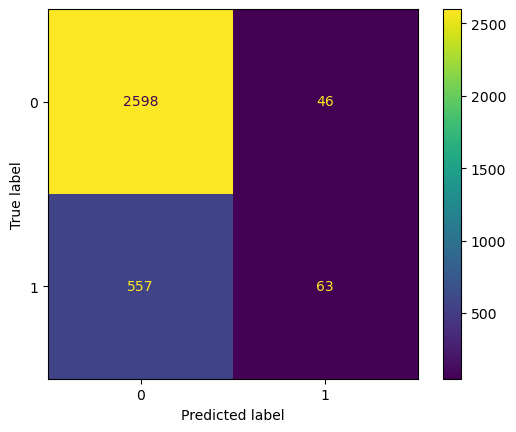

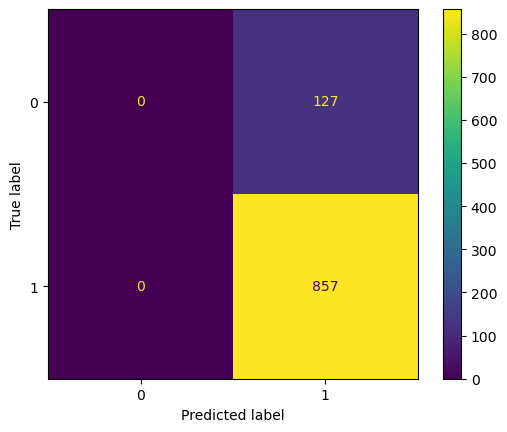

In [24]:
# confusion matrix for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ab = AdaBoost()
    ab.fit(X_train, y_train)
    plot_cm(ab, X_test, y_test)


In [25]:
# unable to test ROC Curve because our implementation doesnt have a "predict_proba" method

In [26]:
# function to plot the Learning Curve of a fitted model
def plot_learning_curves(model, X, y, title=''):
    training_size = np.linspace(0.1,0.9,10)

    train_scores = {}
    test_scores = {}
    for tr_size in training_size:
        train_scores[tr_size] = []
        test_scores[tr_size] = []
        # run 10 tests with training size = tr_size and store all accuracy results in a line of train_scores and test_scores
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=tr_size)
            model.fit(X_train, y_train)
            training_pred = model.predict(X_train)
            testing_pred = model.predict(X_test)
            train_scores[tr_size].append(accuracy_score(training_pred, y_train))
            test_scores[tr_size].append(accuracy_score(testing_pred, y_test))
        # print some statistics
        print(
            f"Train size: {tr_size}\n \
            Mean training score: {round(np.mean(train_scores[tr_size]), 5)}\n \
            Standard deviation: {round(np.std(train_scores[tr_size]), 5)}"
        )

    train_mean = np.array([np.mean(train_scores[tr_size]) for tr_size in training_size])
    train_std = np.array([np.std(train_scores[tr_size]) for tr_size in training_size])
    test_mean = np.array([np.mean(test_scores[tr_size]) for tr_size in training_size])
    test_std = np.array([np.std(test_scores[tr_size]) for tr_size in training_size])

    plt.figure(figsize=(8, 6))
    plt.plot(training_size, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(training_size, test_mean, 'o-', color='green', label='Test score')
    plt.fill_between(training_size, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(training_size, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()


Train size: 0.1
             Mean training score: 1.0
             Standard deviation: 0.0
Train size: 0.18888888888888888
             Mean training score: 1.0
             Standard deviation: 0.0
Train size: 0.2777777777777778
             Mean training score: 0.99206
             Standard deviation: 0.01235
Train size: 0.3666666666666667
             Mean training score: 0.9832
             Standard deviation: 0.01383
Train size: 0.4555555555555556
             Mean training score: 0.98232
             Standard deviation: 0.00647
Train size: 0.5444444444444445
             Mean training score: 0.97358
             Standard deviation: 0.00751
Train size: 0.6333333333333333
             Mean training score: 0.97685
             Standard deviation: 0.00604
Train size: 0.7222222222222222
             Mean training score: 0.97505
             Standard deviation: 0.00552
Train size: 0.8111111111111111
             Mean training score: 0.97089
             Standard deviation: 0.00383
Train

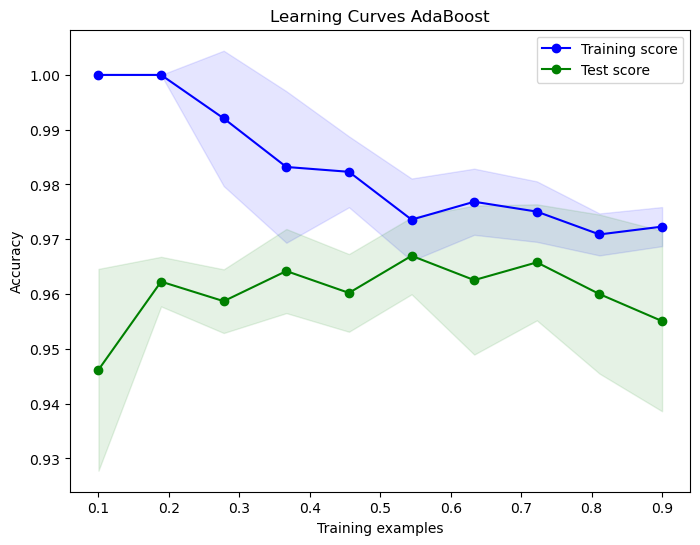

Train size: 0.1
             Mean training score: 0.97855
             Standard deviation: 0.00737
Train size: 0.18888888888888888
             Mean training score: 0.98218
             Standard deviation: 0.0043
Train size: 0.2777777777777778
             Mean training score: 0.98143
             Standard deviation: 0.00699
Train size: 0.3666666666666667
             Mean training score: 0.98052
             Standard deviation: 0.00472
Train size: 0.4555555555555556
             Mean training score: 0.97997
             Standard deviation: 0.00412
Train size: 0.5444444444444445
             Mean training score: 0.97692
             Standard deviation: 0.00524
Train size: 0.6333333333333333
             Mean training score: 0.9782
             Standard deviation: 0.0062
Train size: 0.7222222222222222
             Mean training score: 0.97971
             Standard deviation: 0.00507
Train size: 0.8111111111111111
             Mean training score: 0.97822
             Standard deviation:

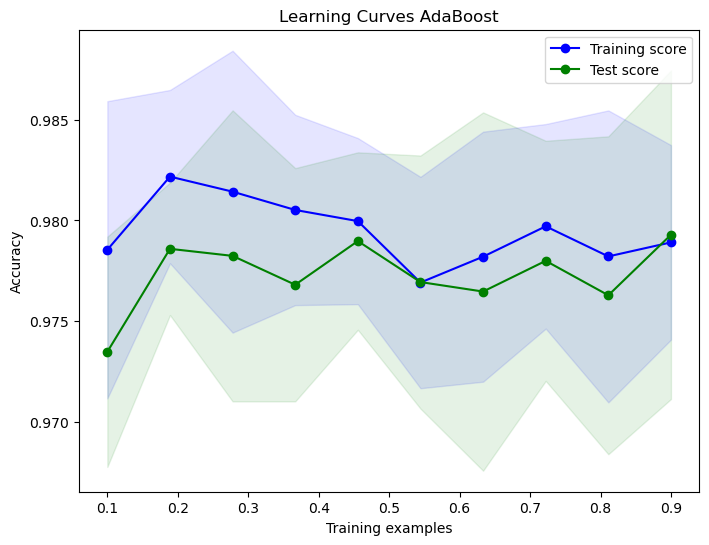

Train size: 0.1
             Mean training score: 0.82169
             Standard deviation: 0.01058
Train size: 0.18888888888888888
             Mean training score: 0.82049
             Standard deviation: 0.00486
Train size: 0.2777777777777778
             Mean training score: 0.81741
             Standard deviation: 0.00736
Train size: 0.3666666666666667
             Mean training score: 0.81459
             Standard deviation: 0.00474
Train size: 0.4555555555555556
             Mean training score: 0.81295
             Standard deviation: 0.00491
Train size: 0.5444444444444445
             Mean training score: 0.81177
             Standard deviation: 0.00416
Train size: 0.6333333333333333
             Mean training score: 0.81313
             Standard deviation: 0.00293
Train size: 0.7222222222222222
             Mean training score: 0.8127
             Standard deviation: 0.00253
Train size: 0.8111111111111111
             Mean training score: 0.81156
             Standard deviatio

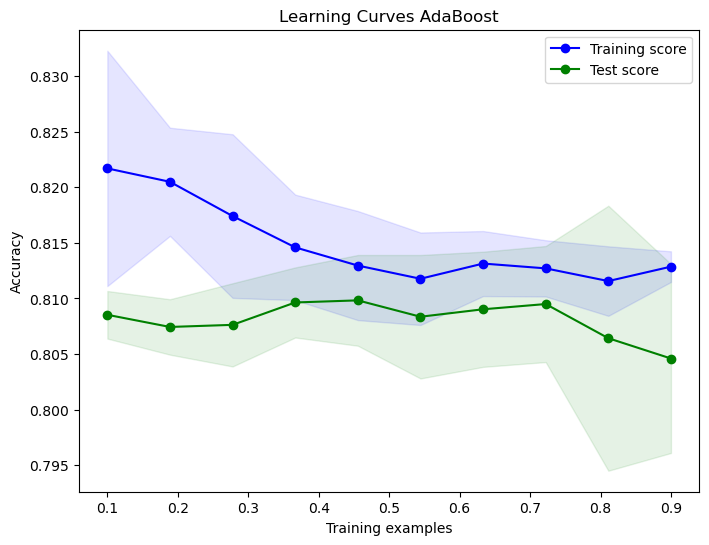

Train size: 0.1
             Mean training score: 0.85443
             Standard deviation: 0.01429
Train size: 0.18888888888888888
             Mean training score: 0.86882
             Standard deviation: 0.01288
Train size: 0.2777777777777778
             Mean training score: 0.86033
             Standard deviation: 0.00943
Train size: 0.3666666666666667
             Mean training score: 0.86048
             Standard deviation: 0.00576
Train size: 0.4555555555555556
             Mean training score: 0.86008
             Standard deviation: 0.0101
Train size: 0.5444444444444445
             Mean training score: 0.86661
             Standard deviation: 0.00828
Train size: 0.6333333333333333
             Mean training score: 0.86161
             Standard deviation: 0.0052
Train size: 0.7222222222222222
             Mean training score: 0.8633
             Standard deviation: 0.00684
Train size: 0.8111111111111111
             Mean training score: 0.8595
             Standard deviation: 

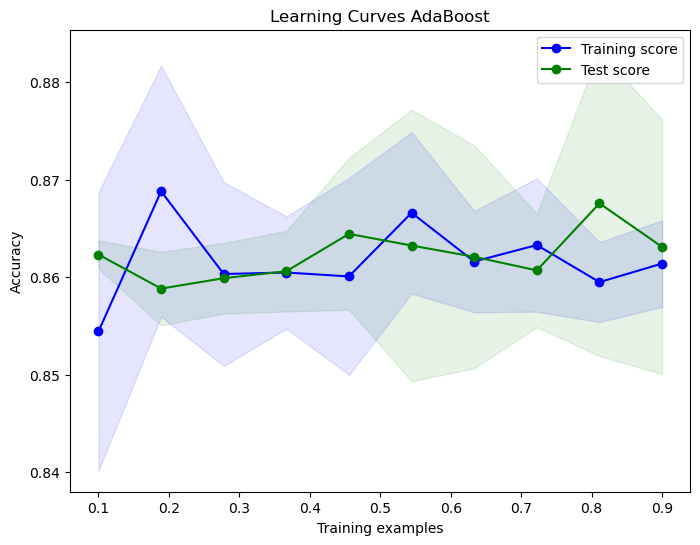

In [27]:
# Learning Cruve for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    ab = AdaBoost()
    plot_learning_curves(ab, X, y, title="AdaBoost")

### Comparision of base algorithm and modified ones

In [28]:
# define the models
models = [
    ("default", AdaBoost()),
    ("Alpha 1", AdaBoost(1)),
    ("Alpha 2", AdaBoost(2)),
    ("Alpha 3", AdaBoost(3)),
]

In [29]:
# function to plot the results from 
def plot_cv(results_cv,metric='Accuracy', title="Cross-validation results for multiple algorithms in a single task"):
    fig, ax = plt.subplots()
    ax.boxplot(results_cv)
    ax.set_xticklabels(results_cv.columns)
    ax.set_ylabel(metric)
    ax.set_title(title)
    plt.show()

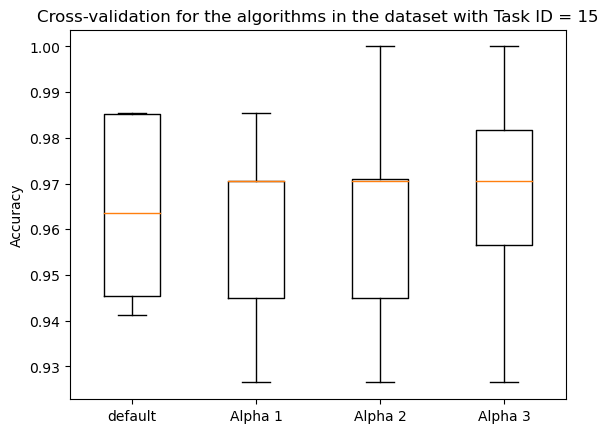

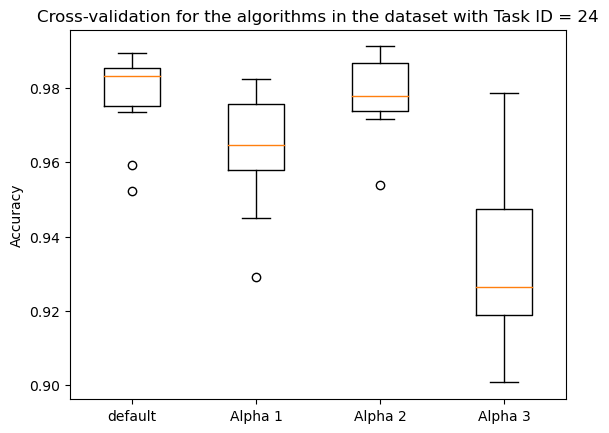

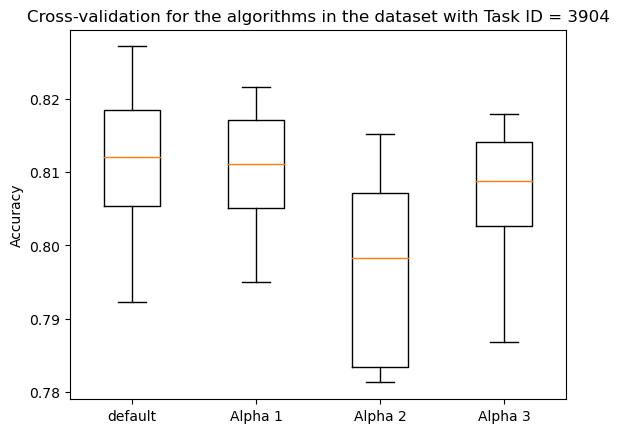

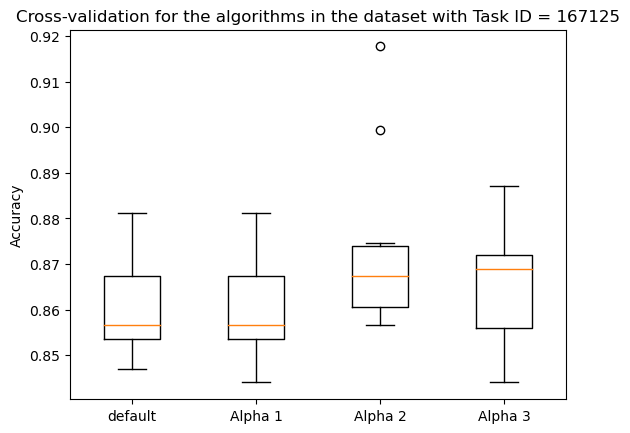

In [30]:
# run 10-fold cross-validation on all algorithms and plot estimates
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']
    results = run_cv(X, y, models)
    plot_cv(results, title=f"Cross-validation for the algorithms in the dataset with {ds_id}")
    

In [34]:
X = datasets[3][1].drop(columns=['target'], axis=1)
y = datasets[3][1]['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
for alg_name, alg in models:
    alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)
    print(y_pred.value_counts())


-1    1413
 1      39
dtype: int64
-1    1452
dtype: int64
-1    1427
 1      25
dtype: int64
-1    1452
dtype: int64
